-------- > epoch 1:  coût moyen entraînement = 2.3127503395080566
-------- > epoch 1:  taux moyen entraînement = 0.10588002949953079
-------- > epoch 1:  coût moyen validation = 2.309460163116455
-------- > epoch 1:  taux moyen validation = 0.10179998725652695
-------- > epoch 2:  coût moyen entraînement = 2.30346941947937
-------- > epoch 2:  taux moyen entraînement = 0.1092800423502922
-------- > epoch 2:  coût moyen validation = 2.3048715591430664
-------- > epoch 2:  taux moyen validation = 0.10909999161958694
-------- > epoch 3:  coût moyen entraînement = 2.3025593757629395
-------- > epoch 3:  taux moyen entraînement = 0.10842005163431168
-------- > epoch 3:  coût moyen validation = 2.3039252758026123
-------- > epoch 3:  taux moyen validation = 0.10909999161958694
-------- > epoch 4:  coût moyen entraînement = 2.3027455806732178
-------- > epoch 4:  taux moyen entraînement = 0.1089000254869461
-------- > epoch 4:  coût moyen validation = 2.3032307624816895
-------- > epoch 4:  t

-------- > epoch 33:  coût moyen entraînement = 0.09486840665340424
-------- > epoch 33:  taux moyen entraînement = 0.9713602066040039
-------- > epoch 33:  coût moyen validation = 0.09309908002614975
-------- > epoch 33:  taux moyen validation = 0.9719003438949585
-------- > epoch 34:  coût moyen entraînement = 0.08621212840080261
-------- > epoch 34:  taux moyen entraînement = 0.9739805459976196
-------- > epoch 34:  coût moyen validation = 0.08626685291528702
-------- > epoch 34:  taux moyen validation = 0.9732001423835754
-------- > epoch 35:  coût moyen entraînement = 0.08065152168273926
-------- > epoch 35:  taux moyen entraînement = 0.9752607941627502
-------- > epoch 35:  coût moyen validation = 0.07724771648645401
-------- > epoch 35:  taux moyen validation = 0.9755001068115234
-------- > epoch 36:  coût moyen entraînement = 0.07348919659852982
-------- > epoch 36:  taux moyen entraînement = 0.9776204824447632
-------- > epoch 36:  coût moyen validation = 0.07853983342647552
-

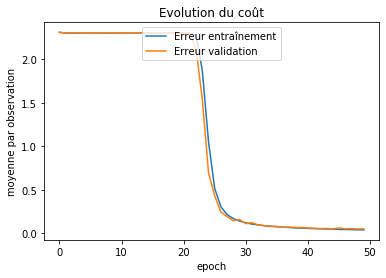

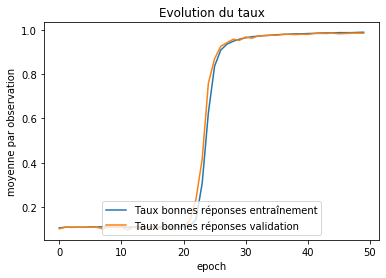

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple MNIST avec réseau LeNet (LeCun et al.)
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA

modele = torch.nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), #(N, 1, 28, 28) -> (N, 6, 28, 28)
    nn.AvgPool2d(kernel_size=2, stride=2), #(N, 6, 28, 28) -> (N, 6, 14, 14)
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), #(N, 6, 14, 14) -> (N, 16, 10, 10)
    nn.AvgPool2d(kernel_size=2, stride=2), #(N, 16, 10, 10) -> (N, 16, 5, 5)
    nn.Flatten(), #(N, 16, 5, 5) -> (N, 400)
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), #(N, 400) -> (N, 120)
    nn.Linear(120, 84), nn.Sigmoid(), #(N, 120) -> (N, 84)
    nn.Linear(84, 10)) #(N, 84) -> (N, 10)

from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.5)

import torchvision
import torchvision.transforms as transforms

#Chargement des données
ds = torchvision.datasets.MNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
ds_ent, ds_valid = torch.utils.data.random_split(ds, [50000, 10000])
ds_test = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

#Création du DataLoader avec le dataset
dl_ent = torch.utils.data.DataLoader(ds_ent, batch_size=100, shuffle = True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='lower center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=50)

In [1]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for une_couche in modele:
    X = une_couche(X)
    print('Type de couche:',une_couche.__class__.__name__,'  Forme de sortie:',X.shape)

NameError: name 'torch' is not defined

-------- > epoch 1:  coût moyen entraînement = 0.0011730216210708022
-------- > epoch 1:  taux moyen entraînement = 0.9999599456787109
-------- > epoch 1:  coût moyen validation = 0.02290450781583786
-------- > epoch 1:  taux moyen validation = 0.9934998154640198
-------- > epoch 2:  coût moyen entraînement = 0.0014617282431572676
-------- > epoch 2:  taux moyen entraînement = 0.9998399019241333
-------- > epoch 2:  coût moyen validation = 0.02277243696153164
-------- > epoch 2:  taux moyen validation = 0.9932998418807983
-------- > epoch 3:  coût moyen entraînement = 0.0011783367954194546
-------- > epoch 3:  taux moyen entraînement = 0.9999199509620667
-------- > epoch 3:  coût moyen validation = 0.022699857130646706
-------- > epoch 3:  taux moyen validation = 0.9931998252868652
-------- > epoch 4:  coût moyen entraînement = 0.0011863978579640388
-------- > epoch 4:  taux moyen entraînement = 0.9998999834060669
-------- > epoch 4:  coût moyen validation = 0.02314028888940811
-------

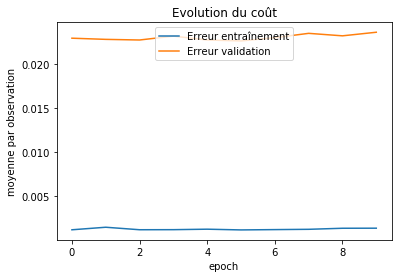

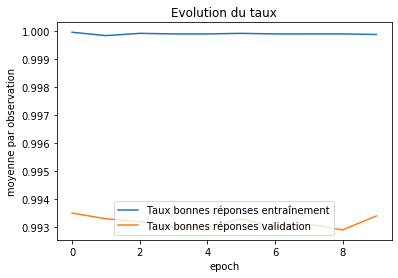

In [23]:
optimiseur = optim.SGD(modele.parameters(), lr=0.001)
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)